<a href="https://www.kaggle.com/code/hoingcnguynphng/car-price-eda-and-imputers-with-pyspark?scriptVersionId=262037060" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Car Price Prediction with PySpark
## data-info: Used cars in United States for sale
## data-source: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 

# 1. Installation

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 10.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.4-py2.py3-none-any.whl size=311905483 sha256=f4e093052ac8f6be0205bfb916125b3b163f78cb76f284ec811fb036fdbbcd23
  Stored in directory: /root/.cache/pip/wheels/4e/66/db/939eb1c49afb8a7fd2c4e393ad34e12b77db67bb4cc974c00e
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5


# 2. Import Necessary Modules

In [2]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql import types, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, round

from pyspark.ml import Transformer, Estimator, Model, Pipeline
from pyspark.ml.param.shared import Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import DataFrame
from pyspark.sql.functions import broadcast

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans

# 3. Create a Spark Session

In [3]:
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
spark.sparkContext.setCheckpointDir("/kaggle/working/checkpoints")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/15 23:01:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


# 4. Read the file

In [4]:
file_path = '../input/craigslist-carstrucks-data/vehicles.csv'
df_cars = spark.read.options(header=True, inferSchema=True, delimiter=',', multiLine=True).csv(file_path)

# 5. EDA

Create templete in order to use SQL and DataFrame API

In [5]:
df_cars.createOrReplaceTempView('cardata')

25/09/15 23:01:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Overview

### Data structure

In [6]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null


The Craigslist Cars dataset contains used car listings in the U.S., collected periodically from Craigslist. Each record represents a listing with details such as price, condition, manufacturer, specifications, and location.

**1. Identifiers & Metadata**

* `id`, `VIN`: Unique IDs for listings/vehicles → keep for tracking, not ML features.
* `url`, `region_url`, `image_url`: Links → useful for reference, not for modeling.
* `region`, `state`, `county`: Geographic info → useful for location-based analysis.
* `lat`, `long`: Precise coordinates → can be engineered into distance features.
* `posting_date`: Date of listing → important for time trend analysis.

**2. Vehicle Information**

* `price`: Target variable for price prediction.
* `year`, `manufacturer`, `model`: Core features affecting car value.
* `odometer`: Mileage → major factor in depreciation.
* `condition`: Car condition (new, good, salvage, …).
* `cylinders`, `fuel`, `transmission`, `drive`: Key technical specs.
* `title_status`: Legal/ownership status → large effect on price.
* `size`, `type`: Segment info (SUV, sedan, compact, …).
* `paint_color`: Minor influence, but may reveal preferences.

**3. Additional Data**

* `description`: Free-text seller notes → usable with NLP.

---

👉 **Most important features for ML/analysis:**  
`price, year, manufacturer, model, odometer, condition, fuel, cylinders, title_status, transmission, drive, size, type, state, lat, long, posting_date`

**Less relevant / auxiliary:**  
`url, region_url, image_url, description`

**Identifiers / sensitive:**  
`id, VIN`

---

In [7]:
df_sample = df_cars.sample(withReplacement=False, fraction=0.01, seed=42).cache()
df_cars.limit(5).toPandas()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,None,None,None,None,...,None,None,None,None,None,None,az,None,None,None
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,None,None,None,None,...,None,None,None,None,None,None,ar,None,None,None
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,None,None,None,None,...,None,None,None,None,None,None,fl,None,None,None
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,None,None,None,None,...,None,None,None,None,None,None,ma,None,None,None
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,None,None,None,None,...,None,None,None,None,None,None,nc,None,None,None


### Data dictionary

In [8]:
# def show_unique_sample(df, exclude=None, limit=20, sample_frac=0.01, seed=42):
#     exclude = set(exclude) if exclude else set()
    
#     # Resample
#     df_sample = df.sample(withReplacement=False, fraction=sample_frac, seed=seed)
    
#     for colname in df.columns:
#         if colname in exclude:
#             continue
#         print(f"\n=== {colname}: Unique sample values ===")
#         df_sample.select(colname).distinct().show(limit, truncate=False)

# show_unique_sample(
#     df_cars,
#     exclude=["posting_date","id","url","region_url","image_url","description"],
#     limit=5,
#     sample_frac=0.0005
# )

### Comments
* "url", "region_url", "image_url", "description" columns are unnecessary. let's drop them
* It seems pyspark interpreted "lat" and "long, "posting_date" columns as string
* We should clean these columns from alphabetic characters
* And we should check the numeric range of "lat" and "long" columns
* Some categorical columns have own null indicators like "other", set them null

In [9]:
cols_to_drop = ["url", "region_url", "image_url", "description"]
df_cars = df_cars.drop(*cols_to_drop)

In [10]:
def clean_string_columns(df, exclude_cols=None, to_lower=True):
    if exclude_cols is None:
        exclude_cols = []

    exprs = []
    for c, t in df.dtypes:
        if t == "string" and c not in exclude_cols:
            col_expr = F.trim(F.col(c))
            if to_lower:
                col_expr = F.lower(col_expr)
            col_expr = F.regexp_replace(col_expr, r'[^a-z0-9]', '_')
            col_expr = F.regexp_replace(col_expr, r'_+', '_')
            col_expr = F.regexp_replace(col_expr, r'^_|_$', '')
            exprs.append(col_expr.alias(c))
        else:
            exprs.append(F.col(c))
    return df.select(*exprs)


def normalize_cars(df):
    df = (
        df
        # numeric cleaning
        .withColumn("price", F.regexp_replace("price", "[^0-9.]", "").cast(types.DoubleType()))
        .withColumn("odometer", F.regexp_replace("odometer", "[^0-9.]", "").cast(types.DoubleType()))
        .withColumn("year", F.regexp_replace("year", "[^0-9]", "").cast(types.IntegerType()))
        # geo validation
        .withColumn("lat", F.when((F.col("lat") >= -90) & (F.col("lat") <= 90), F.col("lat").cast(types.FloatType())))
        .withColumn("long", F.when((F.col("long") >= -180) & (F.col("long") <= 180), F.col("long").cast(types.FloatType())))
        # posting_date validation
        .withColumn(
            "posting_date",
            F.when(
                F.col("posting_date").rlike(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'),
                F.col("posting_date")
            ).cast(types.TimestampType())
        )
    )

    # string normalization (exclude id, VIN)
    df = clean_string_columns(df, exclude_cols=["id", "VIN",'lat','long'], to_lower=True)

    # state validation
    df = df.withColumn("state", F.when(F.col("state").rlike("^[a-z]{2}$"), F.col("state")))

    return df

df_cars = normalize_cars(df_cars)

### Missing values

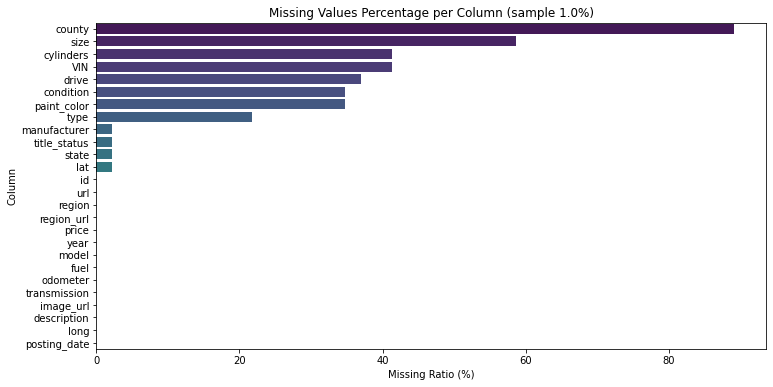

[('county', 41, 89.13043478260869),
 ('size', 27, 58.69565217391305),
 ('cylinders', 19, 41.30434782608695),
 ('VIN', 19, 41.30434782608695),
 ('drive', 17, 36.95652173913043),
 ('condition', 16, 34.78260869565217),
 ('paint_color', 16, 34.78260869565217),
 ('type', 10, 21.73913043478261),
 ('manufacturer', 1, 2.1739130434782608),
 ('title_status', 1, 2.1739130434782608),
 ('state', 1, 2.1739130434782608),
 ('lat', 1, 2.1739130434782608),
 ('id', 0, 0.0),
 ('url', 0, 0.0),
 ('region', 0, 0.0),
 ('region_url', 0, 0.0),
 ('price', 0, 0.0),
 ('year', 0, 0.0),
 ('model', 0, 0.0),
 ('fuel', 0, 0.0),
 ('odometer', 0, 0.0),
 ('transmission', 0, 0.0),
 ('image_url', 0, 0.0),
 ('description', 0, 0.0),
 ('long', 0, 0.0),
 ('posting_date', 0, 0.0)]

In [11]:
def plot_missing_values_spark(df, sample_frac=0.01):
    # Lấy sample nhỏ để giảm memory
    df_sample = df.sample(fraction=sample_frac, seed=42)

    # Tạo list expressions đếm null trên sample
    agg_exprs = [
        F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in df_sample.columns
    ]
    sample_count = df_sample.count()  # chỉ trên sample
    missing_counts = df_sample.agg(*agg_exprs).collect()[0].asDict()

    # Tính ratio
    missing_data = [
        (c, missing_counts[c], missing_counts[c] / sample_count * 100)
        for c in df_sample.columns
    ]
    missing_data.sort(key=lambda x: x[2], reverse=True)

    # Vẽ barplot
    columns, counts, ratios = zip(*missing_data)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(ratios), y=list(columns), palette="viridis")
    plt.title(f"Missing Values Percentage per Column (sample {sample_frac*100:.1f}%)")
    plt.xlabel("Missing Ratio (%)")
    plt.ylabel("Column")
    plt.show()

    return missing_data

missing_df = plot_missing_values_spark(df_sample)
missing_df

Missing value groups:
* **Very high (>70%)**: `county`, `size` → drop.
* **High (30–70%)**: `cylinders`, `condition`, `VIN`, `drive`, `paint_color` → fill with mode/"unknown" or predict from other columns
* **Moderate (10–30%)**: `type`, `lat`, `long`, `posting_date` → fill with median/mode by group
* **Low (<10%)**: `manufacturer`, `title_status`, `model`, `odometer`, `fuel`, `transmission`, `state`, `year` → fill with mode/median
* **No missing**: `region`, `price`, `id` → keep as is


In [12]:
#Title status has dominant cata -> drop
cols_to_drop = ["county","size", "title_status"]
df_cars = df_cars.drop(*cols_to_drop)

In [13]:
cols_expr = [when(col(c).isNull(), 1).otherwise(0) for c in df_cars.columns]
expr = reduce(lambda a, b: a + b, cols_expr)
df_with_null_count = df_cars.withColumn("null_count", expr)
total_rows = df_cars.count()

df_with_null_count.groupBy("null_count")\
    .count()\
    .withColumn("percent", round(col("count") / total_rows * 100, 2))\
    .orderBy(col("null_count").desc())\
    .show()

+----------+------+-------+
|null_count| count|percent|
+----------+------+-------+
|        15|    68|   0.02|
|        12|    30|   0.01|
|        11|   500|   0.12|
|        10|  2732|   0.64|
|         9|  2735|   0.64|
|         8|  3480|   0.82|
|         7| 10217|    2.4|
|         6| 52424|  12.29|
|         5| 27242|   6.39|
|         4| 28037|   6.57|
|         3| 43790|  10.27|
|         2| 82984|  19.45|
|         1|118512|  27.78|
|         0| 53831|  12.62|
+----------+------+-------+



In [14]:
df_cars = df_with_null_count.filter(col("null_count") < 10).drop("null_count")

### Duplicated values

In [15]:
def check_duplicates(df, cols):
    total = df.count()
    unique = df.select(cols).distinct().count()
    dup_count = total - unique
    dup_ratio = dup_count / total * 100
    
    print(f"Total rows: {total}")
    print(f"Unique rows by {cols}: {unique}")
    print(f"Duplicate rows: {dup_count} ({dup_ratio:.2f}%)")

check_duplicates(df_cars, ["id"])

Total rows: 423252
Unique rows by ['id']: 423252
Duplicate rows: 0 (0.00%)


* Drop duplicates excluding "id" feature

In [16]:
exclude_cols = ["id"]

total_rows = df_cars.count()
distinct_rows = df_cars.drop(*exclude_cols).distinct().count()
duplicates = total_rows - distinct_rows

print("Total rows:", total_rows)
print("Distinct rows (excluding certain columns):", distinct_rows)
print("Duplicated rows:", duplicates)

df_cars = df_cars.dropDuplicates(subset=[c for c in df_cars.columns if c not in exclude_cols])

Total rows: 423252
Distinct rows (excluding certain columns): 414743
Duplicated rows: 8509


## Numeric features

### Descriptive Statistics
#### Hint: If data is too big you can sample it before the descriptive stat calculations

In [17]:
df_sample.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+------------------+------------------+------------------+--------------------+--------------------+
|summary|             price|              year|          odometer|                 lat|                long|
+-------+------------------+------------------+------------------+--------------------+--------------------+
|  count|              4261|              4254|              4201|                4218|                4237|
|   mean|17132.368927481813|2011.3366243535495| 103655.0057129255|   42.69345864964704|  -88.08959912420323|
| stddev| 15659.16086187676| 8.764762212885014|278544.54932763695|   98.08873676329154|   111.3443761035685|
|    min|                 0|              1901|                 0|                 ...|                 ...|
|    25%|              5500|              2008|             38764|           34.758445|             -110.96|
|    50%|             13400|              2013|             87351|           39.081944|          -88.033653|
|    75%|          

**1. `price`**
* Min = `0.0` → invalid (cars can’t be free).
* Max = `3,736,928,711` → extreme outlier, likely data error.
* Very high stddev → heavily right skewed distribution with extreme values.

👉 **Suggested handling**

* Drop `price <= 0` (likely placeholders/test).
* Consider log-transform (`log1p(price)`) to reduce skew for modeling.

---

**2. `year`**

* Min = `1900` → unrealistic (maybe cars weren’t available then).
* Max = `2022` → valid (latest crawl).
* Median ≈ `2013`.
  
👉 **Suggested handling**

* By reading through the wikipedia page of Automotive industry in the United States, It seems that the car sales grew to large numbers during the 1960s, ignore `year < 1960`.
---

**3. `odometer`**
* Min = `0.0` → possible (brand new cars) but may also indicate missing.
* Max = `10,000,000` → unrealistic outlier.
* Mean ≈ `98k` miles → reasonable.
* Right skewed distribution with extreme values.

👉 **Suggested handling**
* Normalize mileage by age (e.g., miles per year).
* Consider log-transform (`log1p(price)`) to reduce skew for modeling.
---

**4. `lat` & `long`**
* `lat = -84` → outside the U.S.
* `long = 173.88` → in Asia, not U.S.
* Mean lat ≈ 38, long ≈ -92 → consistent with U.S. center.

👉 **Suggested handling**
* Keep only U.S. ranges:
  * `lat ∈ [24, 50]`
  * `long ∈ [-125, -65]`
* Set out-of-range records to null or drop them.

In [18]:
def plot_outliers_iqr(df, col):
    # Convert to Pandas
    pdf = df.select(col).dropna().toPandas()
    
    # Compute IQR
    Q1 = pdf[col].quantile(0.25)
    Q3 = pdf[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    print(f"Column: {col}")
    print(f"Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"Lower bound={lower:.2f}, Upper bound={upper:.2f}")
    print(f"Outliers count={((pdf[col] < lower) | (pdf[col] > upper)).sum()} / {len(pdf)}")
    
    # Plot distribution + boxplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    sns.histplot(pdf[col], bins=50, kde=True, ax=axes[0])
    axes[0].axvline(lower, color='r', linestyle='--')
    axes[0].axvline(upper, color='r', linestyle='--')
    axes[0].set_title(f"Histogram of {col}")
    
    # Boxplot
    sns.boxplot(x=pdf[col], ax=axes[1])
    axes[1].axvline(lower, color='r', linestyle='--')
    axes[1].axvline(upper, color='r', linestyle='--')
    axes[1].set_title(f"Boxplot of {col}")
    
    plt.show()

#### Price
* Price column still have many outliers arcording to IQR, might remove high-valid value -> Use quantile 0.99 for upper bound, and 0 for lower bound

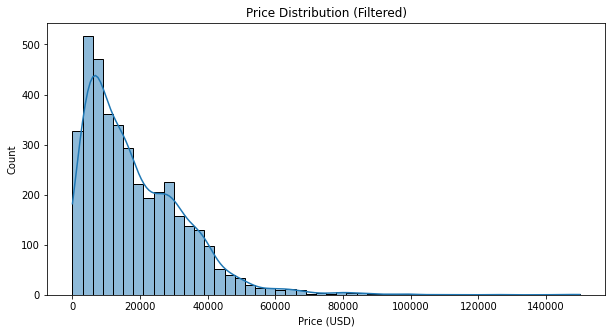

In [19]:
price_df = df_sample.select("price") \
    .where("price > 0 AND price < 150000") \
    .toPandas()

plt.figure(figsize=(10,5))
sns.histplot(price_df["price"], bins=50, kde=True)
plt.title("Price Distribution (Filtered)")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

Column: price
Q1=5500.00, Q3=25991.00, IQR=20491.00
Lower bound=-25236.50, Upper bound=56727.50
Outliers count=82 / 4261


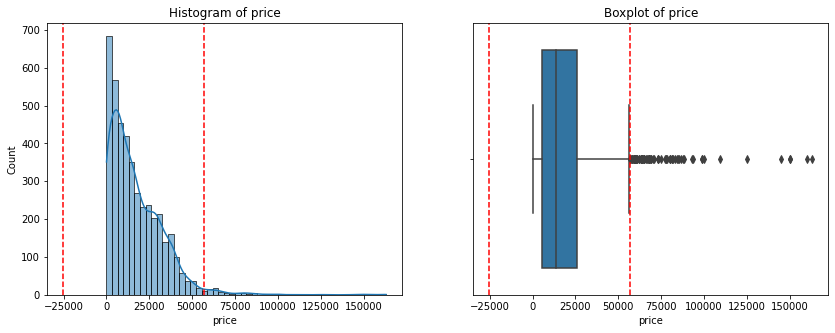

In [20]:
plot_outliers_iqr(df_sample, "price")

#### Year
* Year column still have many outliers in early years -> [1960;2022] arcording to above explaination

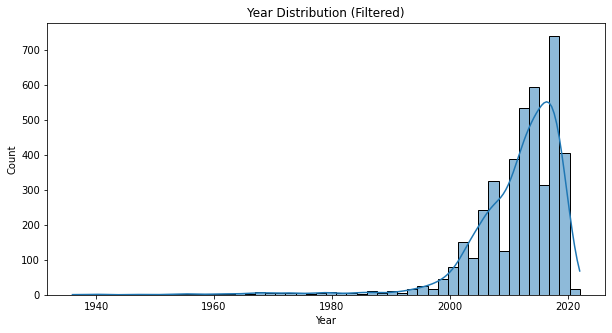

In [21]:
year_df = df_sample.select("year") \
    .where("year > 1930 AND year < 2023") \
    .toPandas()

plt.figure(figsize=(10,5))
sns.histplot(year_df["year"], bins=50, kde=True)
plt.title("Year Distribution (Filtered)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Column: year
Q1=2008.00, Q3=2017.00, IQR=9.00
Lower bound=1994.50, Upper bound=2030.50
Outliers count=132 / 4254


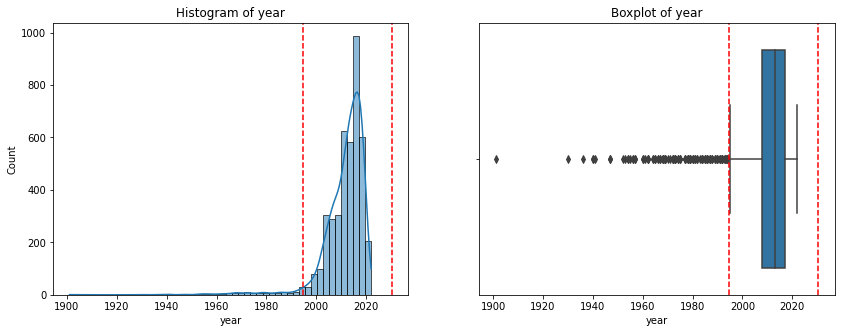

In [22]:
plot_outliers_iqr(df_sample, "year")

#### Odometer
* Odometer column still have many outliers arcording to IQR, might remove high-valid value -> Use quantile 0.99 for upper bound, and 0 for lower bound

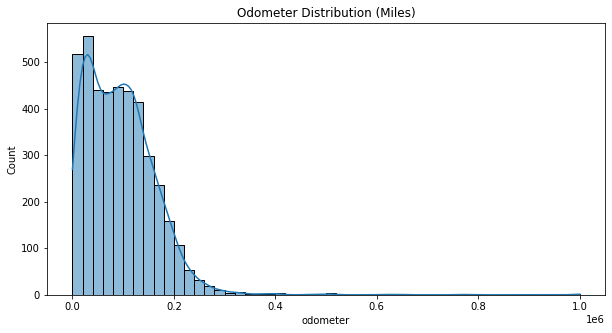

In [23]:
odo_df = df_sample.select("odometer").where("odometer BETWEEN 0 AND 1e6").toPandas()

plt.figure(figsize=(10,5))
sns.histplot(odo_df["odometer"], bins=50, kde=True)
plt.title("Odometer Distribution (Miles)")
plt.show()

Column: odometer
Q1=38764.00, Q3=134000.00, IQR=95236.00
Lower bound=-104090.00, Upper bound=276854.00
Outliers count=49 / 4201


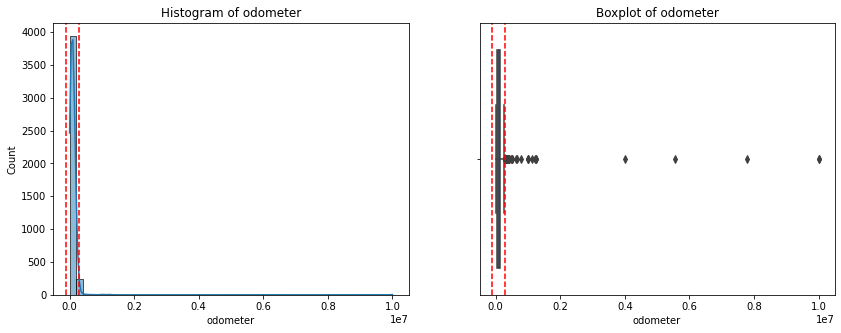

In [24]:
plot_outliers_iqr(df_sample, "odometer")

In [25]:
# --- Price (target) ---
price_q = df_cars.approxQuantile("price", [0.10, 0.99], 0.001)
price_lower, price_upper = 0, price_q[1]

df_cars = df_cars.filter((F.col("price") > price_lower) & (F.col("price") < price_upper))

# --- Year ---
year_lower, year_upper = 1959, 2023

# --- Odometer ---
odo_q = df_cars.approxQuantile("odometer", [0.10, 0.99], 0.001)
odo_lower, odo_upper = -1, odo_q[1]

df_cars = df_cars.withColumn(
    "year",
    F.when((F.col("year") > year_lower) & (F.col("year") < year_upper), F.col("year"))
     .otherwise(F.lit(None))
).withColumn(
    "odometer",
    F.when((F.col("odometer") > odo_lower) & (F.col("odometer") < odo_upper), F.col("odometer"))
     .otherwise(F.lit(None))
)

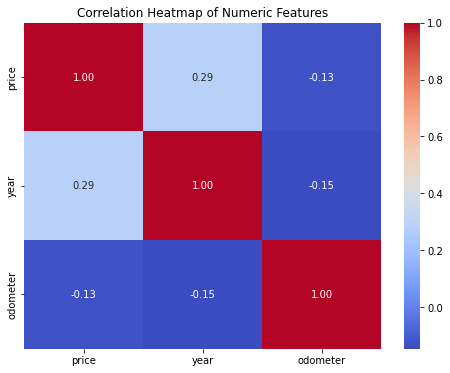

In [26]:
def plot_correlation_heatmap(df, numeric_cols):
    pdf = df.select(numeric_cols).toPandas()
    
    # Compute correlation
    corr = pdf.corr()
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

numeric_cols = ["price", "year", "odometer", "lat", "long"]
plot_correlation_heatmap(df_sample, numeric_cols)

* Correlation increase from ~0.1 -> 0.4, 0.5 after remove outliers, duplicates and some null values
* Lat & Long would be used to extract more meaningful features

## Categorical features

In [27]:
def plot_categorical_distribution(df, col, rotate_xticks=True, top_n=10):
    freq_df = (
        df.groupBy(col)
          .agg(F.count("*").alias("count"))
          .orderBy(F.desc("count"))
    )
    
    pdf = freq_df.limit(top_n).toPandas()
    unique_count = df.select(col).agg(F.countDistinct(col)).collect()[0][0]
    
    # plot
    plt.figure(figsize=(10,5))
    sns.barplot(x=col, y="count", data=pdf, palette="viridis")
    
    title_suffix = f" (Top {top_n})" if unique_count > top_n else ""
    plt.title(f"Distribution of {col}{title_suffix} - {unique_count} unique")
    plt.ylabel("Count")
    plt.xlabel(col)
    
    if rotate_xticks:
        plt.xticks(rotation=45, ha="right")
    
    plt.show()


def plot_all_categoricals(df, cols, rotate_xticks=True, top_n=10):
    for col in cols:
        print(f"\nPlotting {col} ...")
        plot_categorical_distribution(df, col, rotate_xticks=rotate_xticks, top_n=top_n)


Plotting manufacturer ...


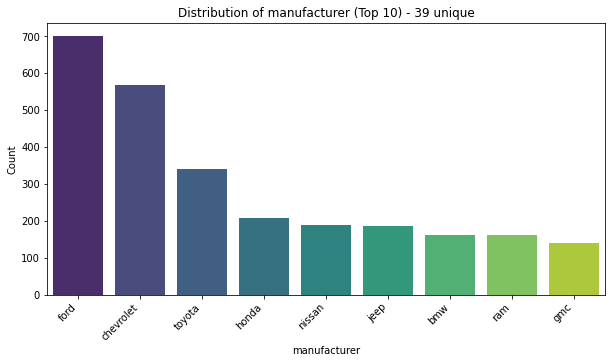


Plotting model ...


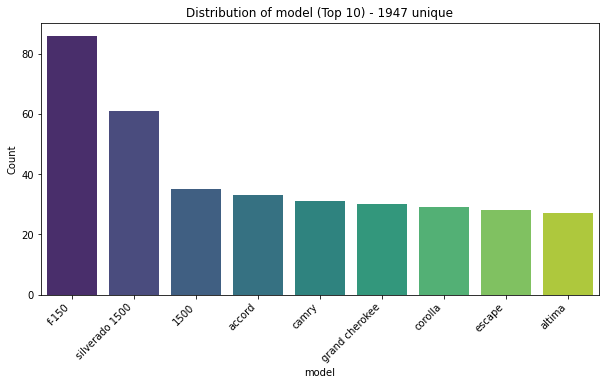


Plotting condition ...


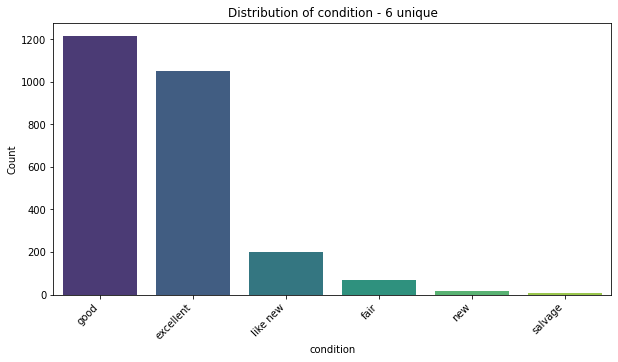


Plotting fuel ...


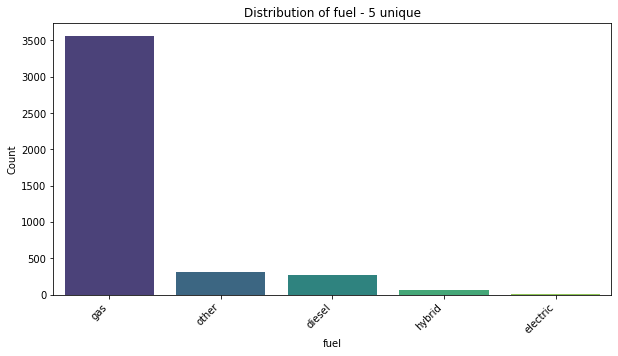


Plotting transmission ...


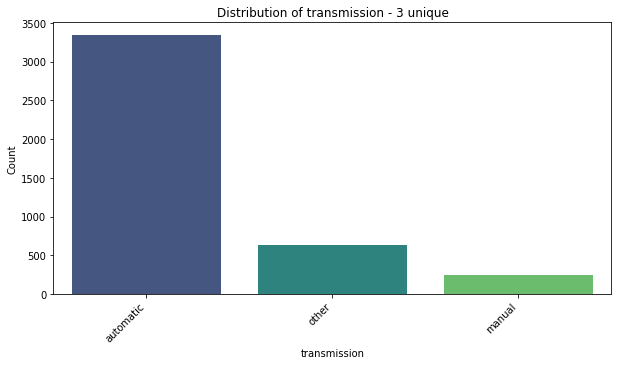


Plotting drive ...


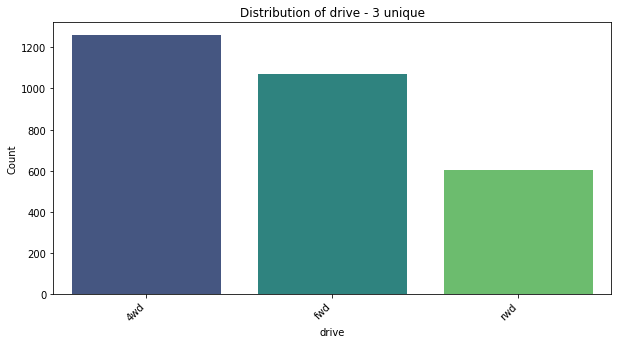


Plotting type ...


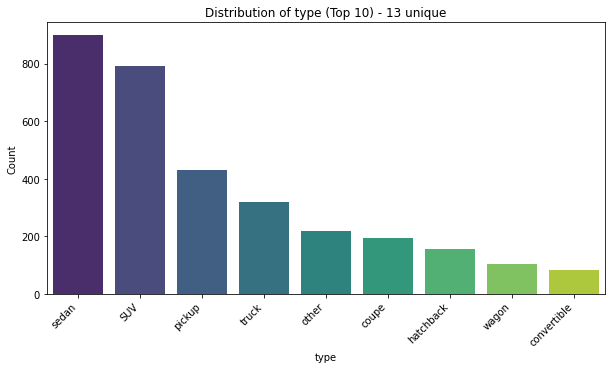


Plotting paint_color ...


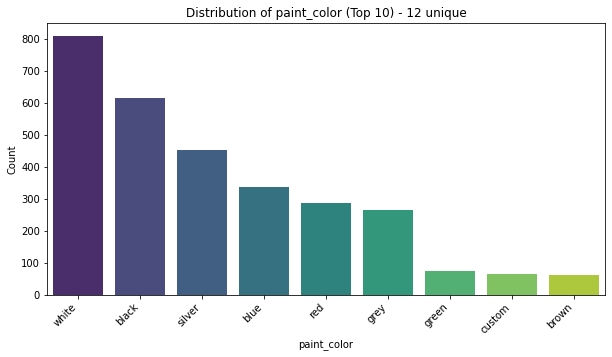


Plotting cylinders ...


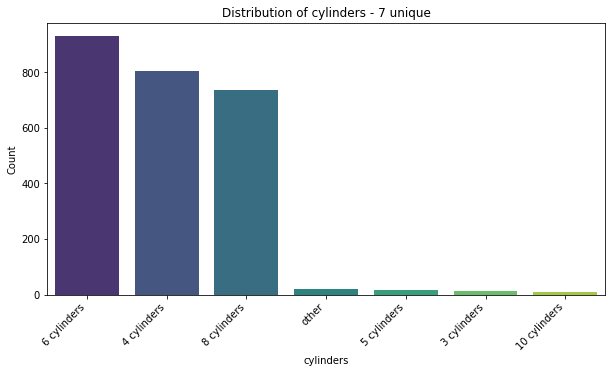

In [28]:
categorical_cols = [
    "manufacturer", "model", "condition", "fuel", "transmission", "drive",
    "type", "paint_color", "cylinders"
]

plot_all_categoricals(df_sample, categorical_cols)

In [29]:
def plot_price_by_category_spark(df, cat_col, agg="median", top_n=10,
                                 sample_frac=0.02, max_sample=20000,
                                 random_state=42, log_scale=False):
    # 1. top-N categories (exclude null)
    top_rows = (
        df.filter(F.col(cat_col).isNotNull())
          .groupBy(cat_col)
          .count()
          .orderBy(F.desc("count"))
          .limit(top_n)
          .collect()
    )
    top_categories = [r[cat_col] for r in top_rows]

    if not top_categories:
        print(f"No non-null categories found for {cat_col}.")
        return

    # 2. Aggregation (median via percentile_approx, or mean)
    if agg == "median":
        agg_expr = F.expr("percentile_approx(price, 0.5)")
        agg_name = "price_median"
    else:
        agg_expr = F.avg("price")
        agg_name = "price_mean"

    agg_df = (
        df.filter(F.col(cat_col).isin(top_categories) & F.col("price").isNotNull())
          .groupBy(cat_col)
          .agg(agg_expr.alias(agg_name), F.count("*").alias("count"))
    )

    pdf_bar = agg_df.orderBy(F.desc(agg_name)).toPandas()

    # 3. Barplot (aggregated)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=agg_name, y=cat_col, data=pdf_bar, palette="viridis")
    plt.title(f"{agg.capitalize()} price by {cat_col} (Top {len(top_categories)})")
    plt.xlabel(agg.replace("_", " ").capitalize())
    plt.ylabel(cat_col)
    if log_scale:
        plt.xscale("log")
    plt.tight_layout()
    plt.show()

    # 4. Boxplot: sample the raw (category, price) pairs
    sample_df = (
        df.filter(F.col(cat_col).isin(top_categories) & F.col("price").isNotNull())
          .select(cat_col, "price")
          .sample(withReplacement=False, fraction=sample_frac, seed=random_state)
    )

    pdf_box = sample_df.toPandas()
    # cap sample size for safety
    if len(pdf_box) > max_sample:
        pdf_box = pdf_box.sample(n=max_sample, random_state=random_state)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x="price", y=cat_col, data=pdf_box, order=pdf_bar[cat_col].tolist())
    plt.title(f"Price distribution by {cat_col} (sampled)")
    plt.xlabel("Price")
    plt.ylabel(cat_col)
    if log_scale:
        plt.xscale("log")
    plt.tight_layout()
    plt.show()


=== MANUFACTURER vs PRICE ===


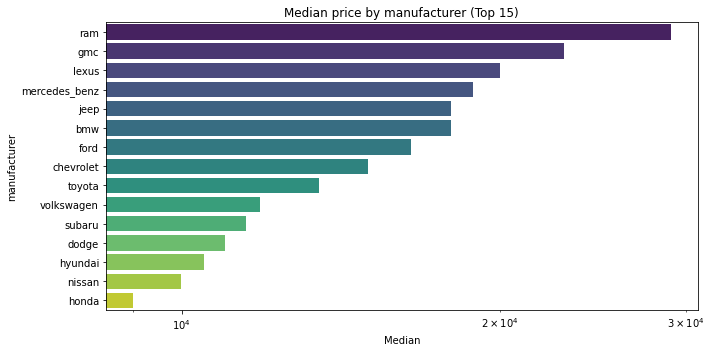

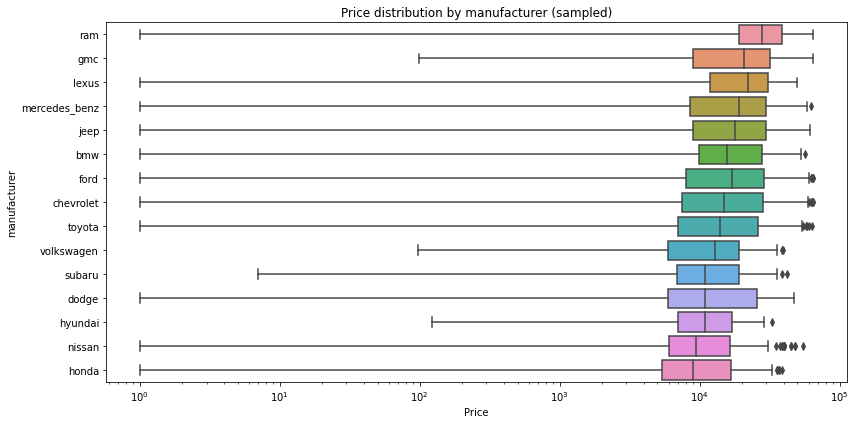


=== MODEL vs PRICE ===


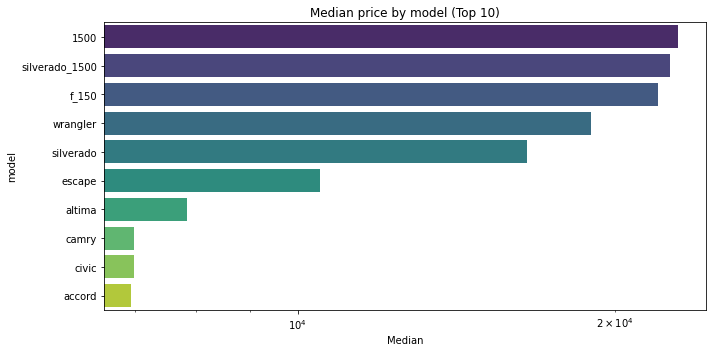

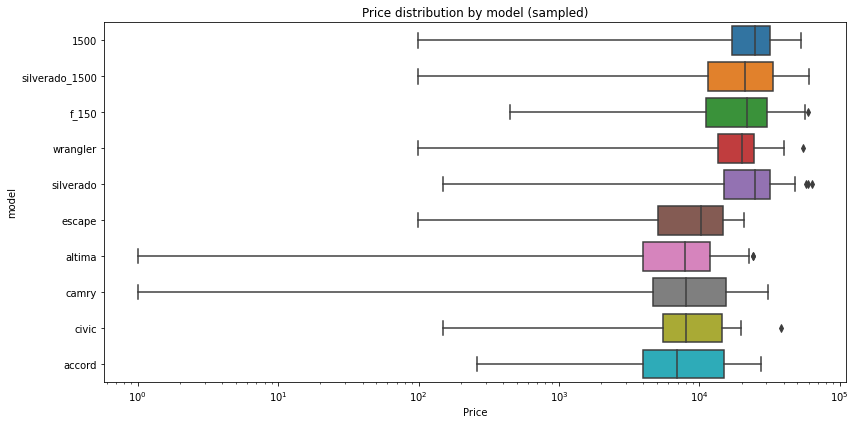


=== CONDITION vs PRICE ===


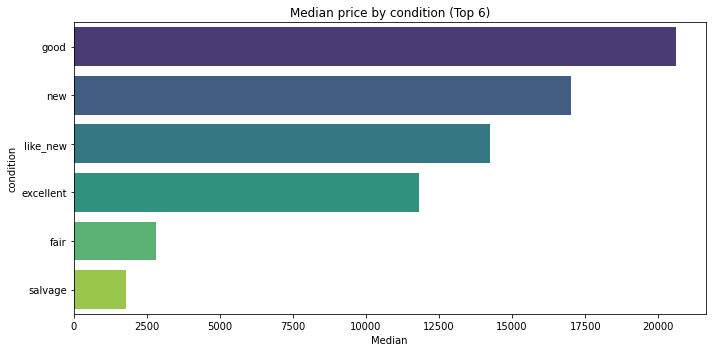

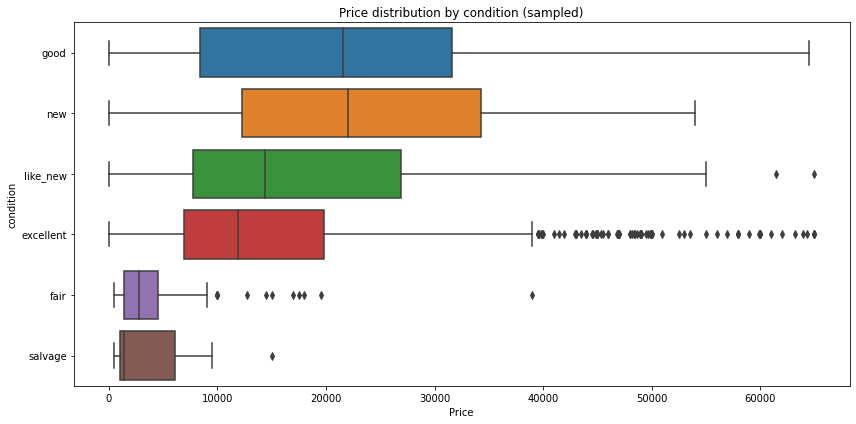


=== FUEL vs PRICE ===


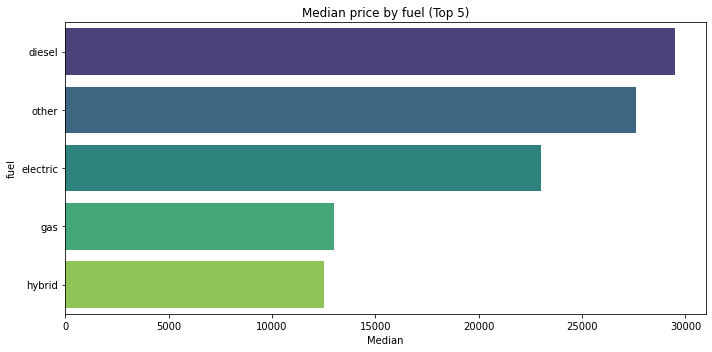

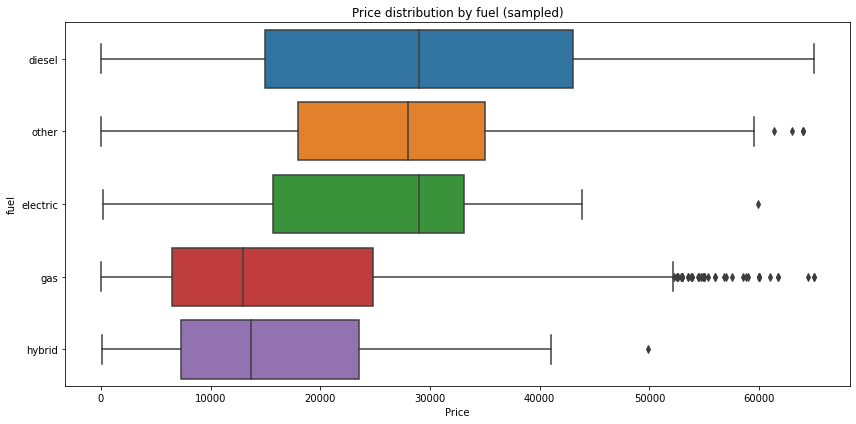


=== TRANSMISSION vs PRICE ===


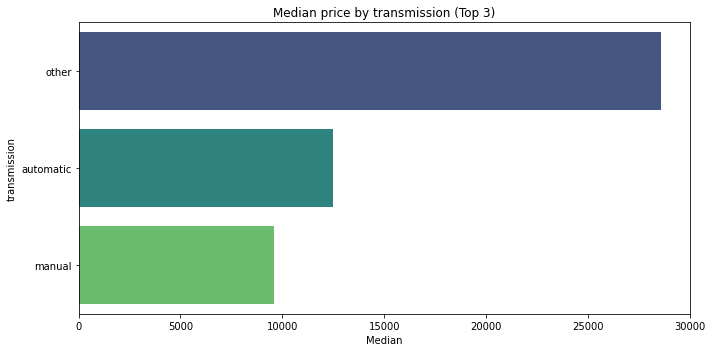

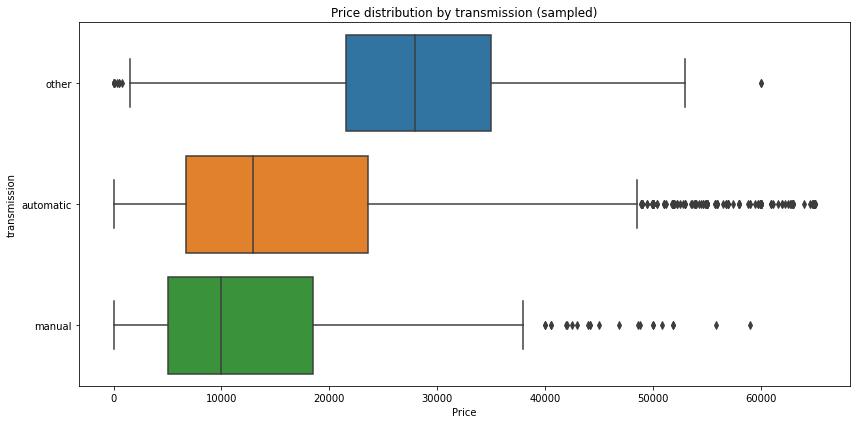


=== DRIVE vs PRICE ===


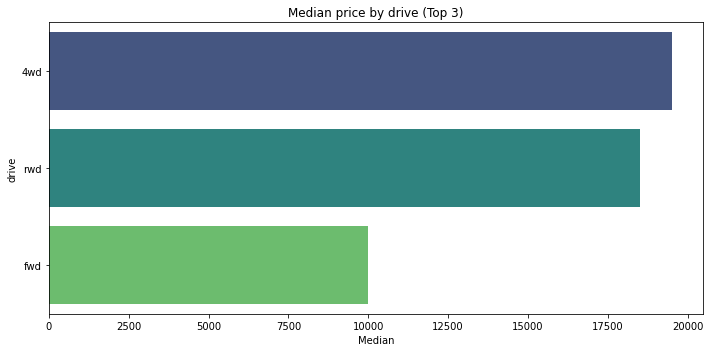

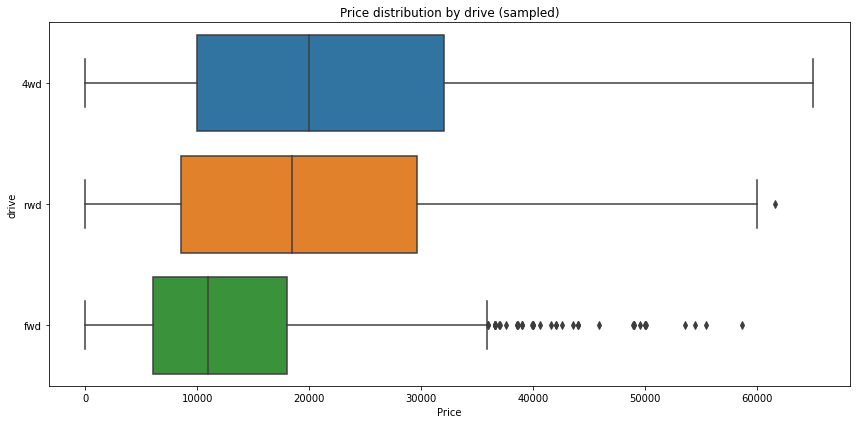


=== TYPE vs PRICE ===


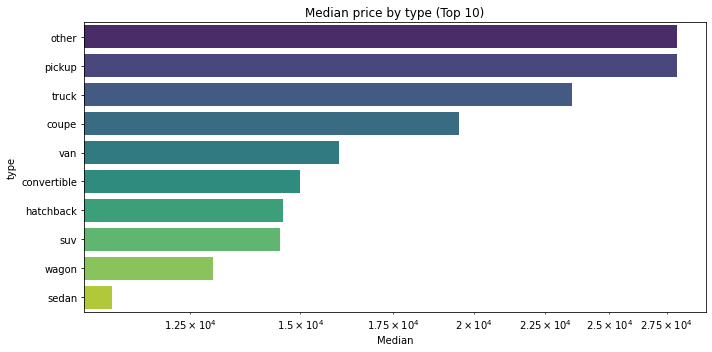

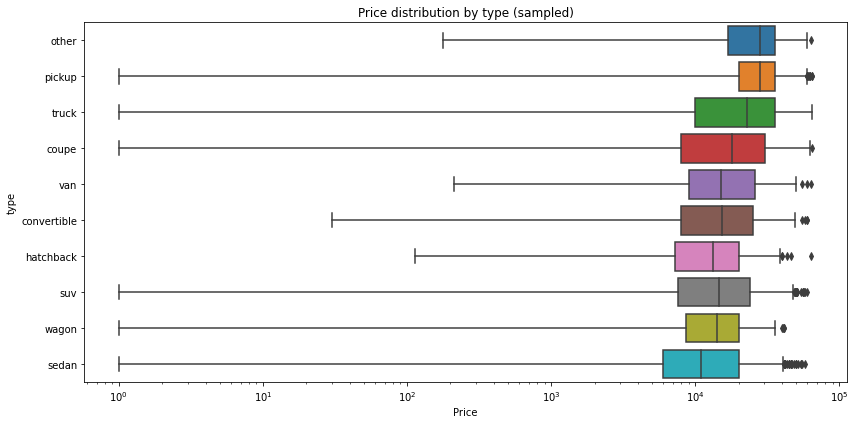


=== PAINT_COLOR vs PRICE ===


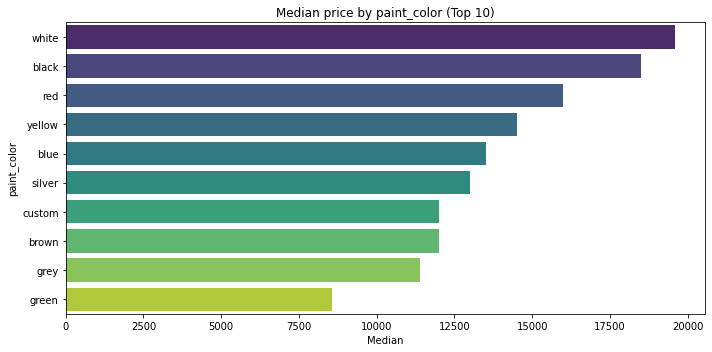

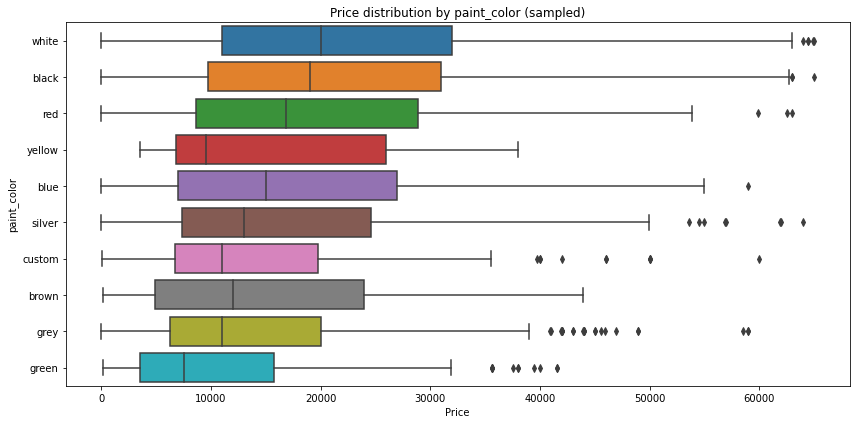


=== CYLINDERS vs PRICE ===


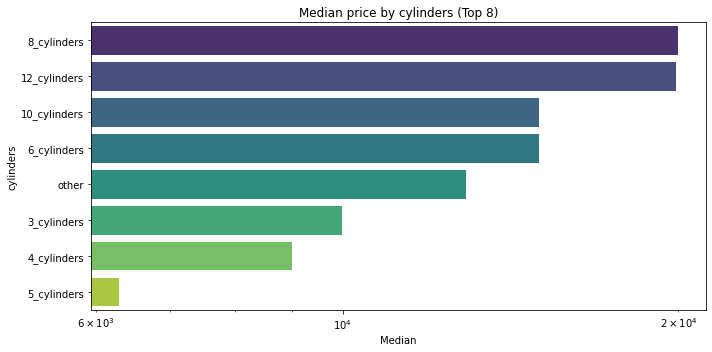

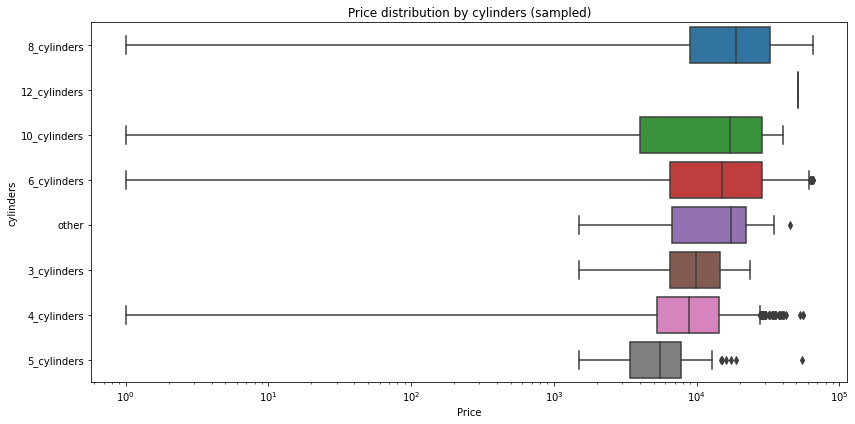

In [30]:
cat_plot_configs = {
    "manufacturer": {"agg": "median", "top_n": 15, "log_scale": True},
    "model": {"agg": "median", "top_n": 10, "log_scale": True},
    "condition": {"agg": "median", "top_n": 10, "log_scale": False},
    "fuel": {"agg": "median", "top_n": 10, "log_scale": False},
    "transmission": {"agg": "median", "top_n": 5, "log_scale": False},
    "drive": {"agg": "median", "top_n": 5, "log_scale": False},
    "type": {"agg": "median", "top_n": 10, "log_scale": True},
    "paint_color": {"agg": "median", "top_n": 10, "log_scale": False},
    "cylinders": {"agg": "median", "top_n": 10, "log_scale": True},
}

for col, cfg in cat_plot_configs.items():
    print(f"\n=== {col.upper()} vs PRICE ===")
    plot_price_by_category_spark(
        df_cars,
        cat_col=col,
        agg=cfg["agg"],
        top_n=cfg["top_n"],
        log_scale=cfg["log_scale"]
    )

## Date / Time Features

In [31]:
df_cars.select(
    F.min("posting_date").alias("min_date"),
    F.max("posting_date").alias("max_date"),
    F.countDistinct("posting_date").alias("unique_dates")
).show()

df_cars.select("posting_date").distinct().orderBy("posting_date").show(10, truncate=False)

+-------------------+-------------------+------------+
|           min_date|           max_date|unique_dates|
+-------------------+-------------------+------------+
|2021-04-04 07:00:25|2021-05-05 04:24:09|      271070|
+-------------------+-------------------+------------+



+-------------------+
|posting_date       |
+-------------------+
|null               |
|2021-04-04 07:00:25|
|2021-04-04 07:00:51|
|2021-04-04 07:01:16|
|2021-04-04 07:03:15|
|2021-04-04 07:08:37|
|2021-04-04 07:10:12|
|2021-04-04 07:10:23|
|2021-04-04 07:10:34|
|2021-04-04 07:10:40|
+-------------------+
only showing top 10 rows



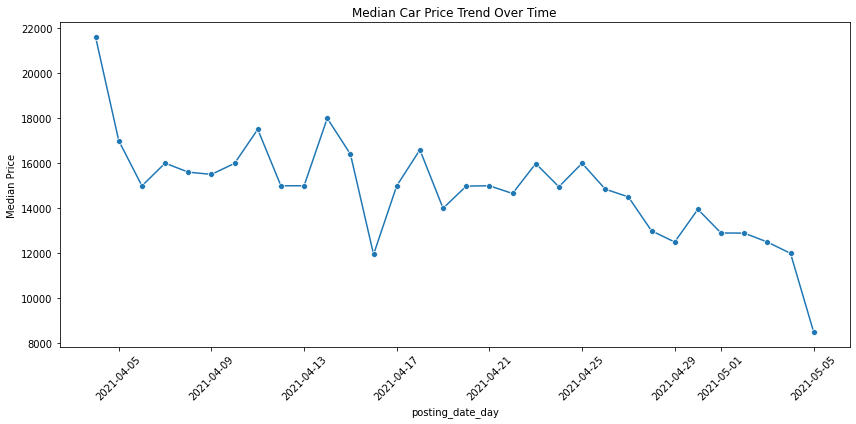

In [32]:
# Aggregate median price per month
trend_df = (
    df_cars.withColumn("posting_date_day", F.to_date("posting_date"))
           .filter(F.col("price").isNotNull())
           .groupBy("posting_date_day")
           .agg(F.expr("percentile_approx(price, 0.5)").alias("median_price"))
           .orderBy("posting_date_day")
           .toPandas()
)
# 5. Lineplot
plt.figure(figsize=(12,6))
sns.lineplot(x="posting_date_day", y="median_price", data=trend_df, marker="o")
plt.title("Median Car Price Trend Over Time")
plt.xlabel("posting_date_day")
plt.ylabel("Median Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Geographical features

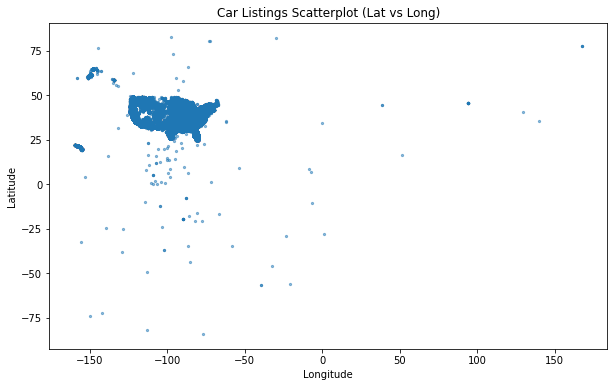

In [33]:
# Convert to Pandas for plotting
geo_df = df_cars.select("lat", "long").toPandas()

# Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(geo_df["long"], geo_df["lat"], s=5, alpha=0.5)
plt.title("Car Listings Scatterplot (Lat vs Long)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

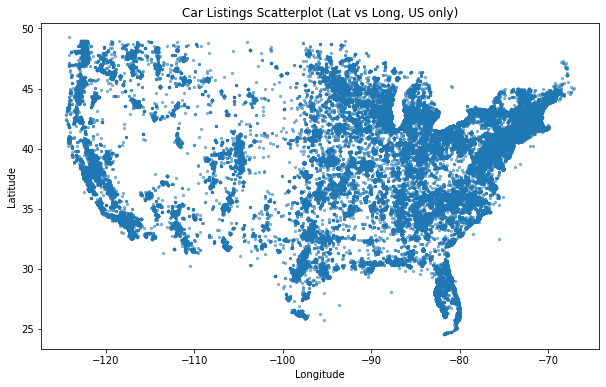

In [34]:
# Filter valid US coordinates (approximate)
df_us = df_cars.filter(
    ((F.col("lat").between(24, 50)) & (F.col("long").between(-125, -65)))
    | (F.col("lat").isNull() | F.col("long").isNull())
).cache()

# Convert to Pandas for plotting
geo_df = df_us.select("lat", "long").toPandas()

# Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(geo_df["long"], geo_df["lat"], s=5, alpha=0.5)
plt.title("Car Listings Scatterplot (Lat vs Long, US only)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [35]:
cond_us = (F.col("lat").between(24, 50)) & (F.col("long").between(-125, -65))

# Đếm trong US và ngoài US
count_us = df_cars.filter(cond_us).count()
count_out = df_cars.filter(~cond_us).count()
count_all = df_cars.count()

print("Total records:", count_all)
print("US records:", count_us, f"({count_us/count_all:.2%})")
print("Outside US records:", count_out, f"({count_out/count_all:.2%})")

Total records: 379120
US records: 333814 (88.05%)
Outside US records: 7412 (1.96%)


* Outside US Records: too much small -> drop


Plotting state ...


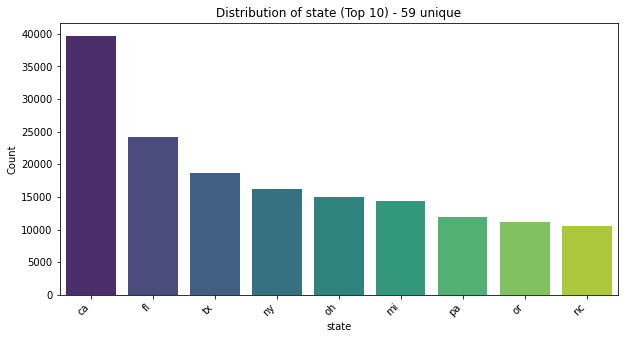


Plotting region ...


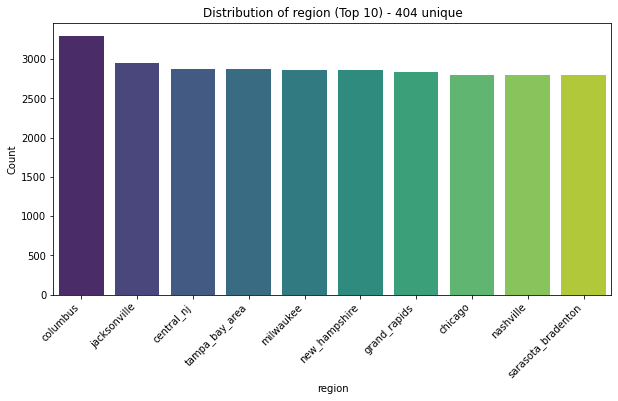

In [36]:
categorical_cols = [
    "state","region"
]

plot_all_categoricals(df_us, categorical_cols)


=== REGION vs PRICE ===


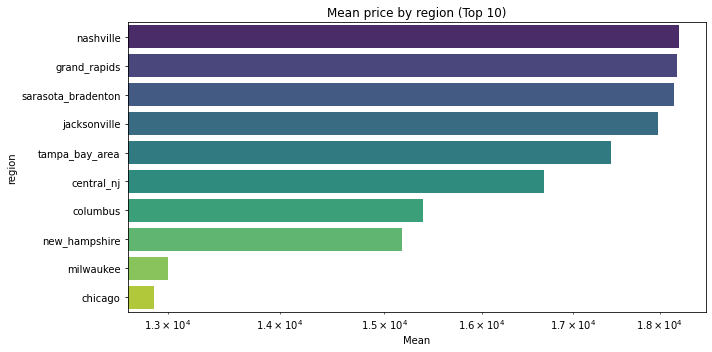

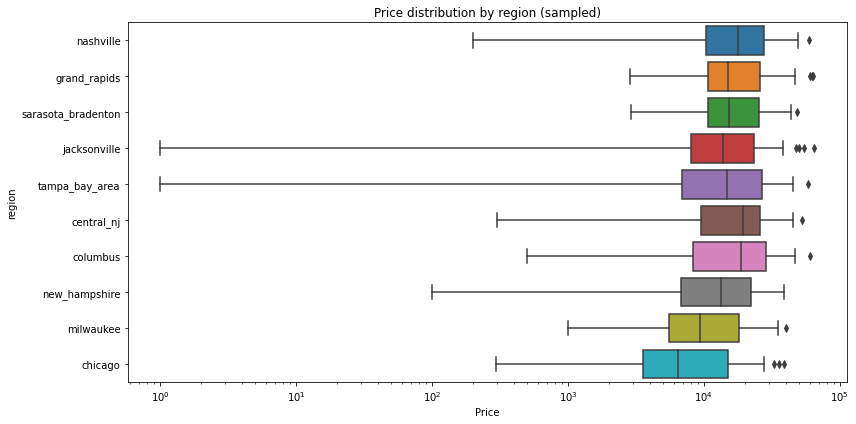


=== STATE vs PRICE ===


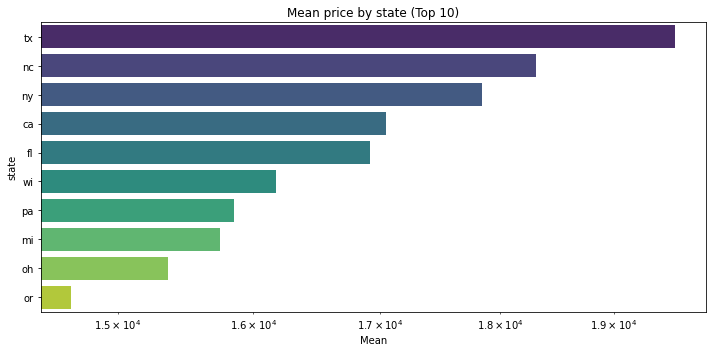

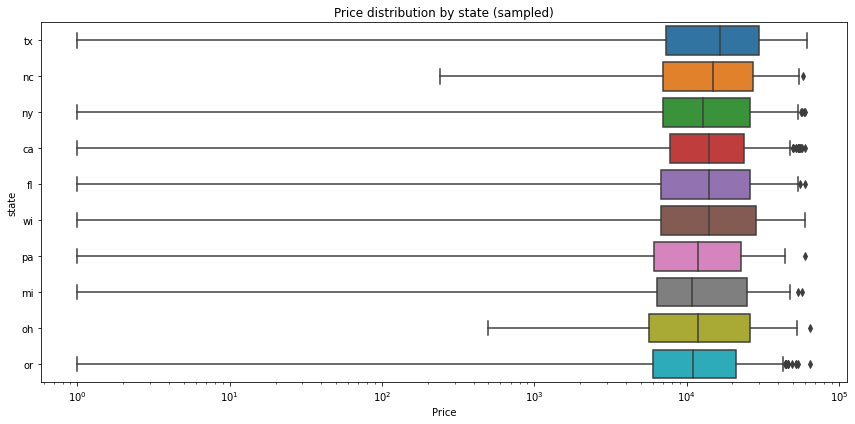

In [37]:
cat_plot_configs = {
    "region": {"agg": "mean", "top_n": 10, "log_scale": True},
    "state": {"agg": "mean", "top_n": 10, "log_scale": True}
}

for col, cfg in cat_plot_configs.items():
    print(f"\n=== {col.upper()} vs PRICE ===")
    plot_price_by_category_spark(
        df_us,
        cat_col=col,
        agg=cfg["agg"],
        top_n=cfg["top_n"],
        log_scale=cfg["log_scale"]
    )

# 6. Preprocessing

## Imputer

In [38]:
df_us = df_us.drop("VIN")
del df_cars
train_df, test_df = df_us.randomSplit([0.8, 0.2], seed=42)
print("Train count:", train_df.count())
print("Test count:", test_df.count())
del df_us

Train count: 299217


Test count: 74396


In [39]:
# ==========================================================
# Step 1: Fill high-missing cols with 'Unknown'
# ==========================================================
class FillUnknown(Transformer):
    def __init__(self, inputCols=None, fillValue="Unknown"):
        super(FillUnknown, self).__init__()
        self.inputCols = inputCols or []
        self.fillValue = fillValue

    def _transform(self, dataset):
        df = dataset
        for col in self.inputCols:
            df = df.withColumn(
                col,
                F.when(F.col(col).isNull(), F.lit(self.fillValue)).otherwise(F.col(col))
            )
        return df

In [40]:
# ==========================================================
# Step 2: Fill categorical mode
# ==========================================================
class FillModeEstimator(Estimator):
    def __init__(self, inputCols=None):
        super(FillModeEstimator, self).__init__()
        self.inputCols = inputCols or []

    def _fit(self, dataset):
        mode_dict = {}
        for col in self.inputCols:
            row = dataset.filter(F.col(col).isNotNull()) \
                         .groupBy(col).count() \
                         .orderBy(F.desc("count")) \
                         .first()
            mode_val = row[0] if row else "unknown"
            mode_dict[col] = mode_val
        return FillModeModel(mode_dict)


class FillModeModel(Model):
    def __init__(self, mode_dict):
        super(FillModeModel, self).__init__()
        self.mode_dict = mode_dict

    def _transform(self, dataset):
        df = dataset
        for col, val in self.mode_dict.items():
            df = df.withColumn(
                col,
                F.when(F.col(col).isNull(), F.lit(val)).otherwise(F.col(col))
            )
        return df

In [41]:
# ==========================================================
# Step 3: Fill numeric median
# ==========================================================
class FillMedianEstimator(Estimator):
    def __init__(self, inputCols=None):
        super(FillMedianEstimator, self).__init__()
        self.inputCols = inputCols or []

    def _fit(self, dataset):
        median_dict = {}
        for col in self.inputCols:
            median_val = dataset.filter(F.col(col).isNotNull()) \
                                .approxQuantile(col, [0.5], 0.01)[0]
            median_dict[col] = median_val
        return FillMedianModel(median_dict)


class FillMedianModel(Model):
    def __init__(self, median_dict):
        super(FillMedianModel, self).__init__()
        self.median_dict = median_dict

    def _transform(self, dataset):
        df = dataset
        for col, val in self.median_dict.items():
            df = df.withColumn(
                col,
                F.when(F.col(col).isNull(), F.lit(val)).otherwise(F.col(col))
            )
        return df

In [42]:
# ==========================================================
# Step 4: Fill Type by Group (Optimized)
# ==========================================================
class FillTypeByGroupEstimator(Estimator):
    def __init__(self, col="type", group_col="manufacturer"):
        super(FillTypeByGroupEstimator, self).__init__()
        self.col = col
        self.group_col = group_col

    def _fit(self, dataset):
        # Global mode
        global_mode_row = dataset.groupBy(self.col).count().orderBy(F.desc("count")).first()
        global_mode = str(global_mode_row[0]) if global_mode_row else "Unknown"

        # Group-specific mode
        group_mode = (
            dataset.filter(F.col(self.col).isNotNull())
                   .groupBy(self.group_col, self.col)
                   .count()
                   .withColumn("rn", F.row_number().over(
                       Window.partitionBy(self.group_col).orderBy(F.desc("count"))
                   ))
                   .filter(F.col("rn") == 1)
                   .select(F.col(self.group_col), F.col(self.col).alias(f"{self.col}_mode"))
        )
        return FillTypeByGroupModel(self.col, self.group_col, global_mode, group_mode)


class FillTypeByGroupModel(Model):
    def __init__(self, col, group_col, global_mode, group_mode_df):
        super(FillTypeByGroupModel, self).__init__()
        self.col = col
        self.group_col = group_col
        self.global_mode = global_mode
        self.group_mode_df = group_mode_df

    def _transform(self, dataset):
        df = dataset.join(broadcast(self.group_mode_df), on=self.group_col, how="left")
        df = df.withColumn(
            self.col,
            F.coalesce(F.col(self.col), F.col(f"{self.col}_mode"), F.lit(self.global_mode))
        ).drop(f"{self.col}_mode")
        return df

In [43]:
# ==========================================================
# Step 5: Fill lat/long by state (Optimized)
# ==========================================================
class FillLatLongByStateEstimator(Estimator):
    def __init__(self, lat_col="lat", long_col="long", state_col="state"):
        super().__init__()
        self.lat_col = lat_col
        self.long_col = long_col
        self.state_col = state_col

    def _fit(self, dataset):
        # Global fallback (median) cho lat/long
        global_lat = dataset.filter(F.col(self.lat_col).isNotNull()) \
                            .approxQuantile(self.lat_col, [0.5], 0.01)[0]
        global_long = dataset.filter(F.col(self.long_col).isNotNull()) \
                             .approxQuantile(self.long_col, [0.5], 0.01)[0]

        # Compute state-specific mode (combined lat+long)
        mode_df = (
            dataset.groupBy(self.state_col, self.lat_col, self.long_col)
                   .count()
                   .withColumn("rn", F.row_number().over(
                       Window.partitionBy(self.state_col).orderBy(F.desc("count"))
                   ))
                   .filter(F.col("rn") == 1)
                   .select(
                       F.col(self.state_col),
                       F.col(self.lat_col).alias("lat_mode"),
                       F.col(self.long_col).alias("long_mode")
                   )
        )

        return FillLatLongByStateModel(
            self.lat_col, self.long_col, self.state_col,
            mode_df, global_lat, global_long
        )


class FillLatLongByStateModel(Model):
    def __init__(self, lat_col, long_col, state_col, mode_df, global_lat, global_long):
        super().__init__()
        self.lat_col = lat_col
        self.long_col = long_col
        self.state_col = state_col
        self.mode_df = mode_df
        self.global_lat = global_lat
        self.global_long = global_long

    def _transform(self, dataset):
        # Join state-specific mode (broadcast)
        df = dataset.join(broadcast(self.mode_df), on=self.state_col, how="left")

        # Fill: ưu tiên state_mode, nếu null fallback global
        df = df.withColumn(
            self.lat_col,
            F.coalesce(
                F.when(F.col(self.lat_col).isNull() | F.col(self.long_col).isNull(),
                       F.col("lat_mode")),
                F.lit(self.global_lat),
                F.col(self.lat_col)
            )
        ).withColumn(
            self.long_col,
            F.coalesce(
                F.when(F.col(self.lat_col).isNull() | F.col(self.long_col).isNull(),
                       F.col("long_mode")),
                F.lit(self.global_long),
                F.col(self.long_col)
            )
        ).drop("lat_mode").drop("long_mode")

        return df

In [44]:
# ==========================================================
# Step 6: ForwardBackwardFillUnion (posting_date)
# ==========================================================
class ForwardBackwardFillUnion:
    def __init__(self, col, new_col=None, group_col=None, order_col=None):
        self.col = col
        self.new_col = new_col or col
        self.group_col = group_col
        self.order_col = order_col

    def transform_train_test(self, train_df, test_df):
        train_tagged = train_df.withColumn("dataset", F.lit("train"))
        test_tagged = test_df.withColumn("dataset", F.lit("test"))
        all_df = train_tagged.unionByName(test_tagged)

        if self.group_col:
            group_cols = [self.group_col, "dataset"] if isinstance(self.group_col, str) else list(self.group_col) + ["dataset"]
        else:
            group_cols = ["dataset"]

        base_window = Window.partitionBy(group_cols).orderBy(self.order_col)
        ffill = F.last(self.col, ignorenulls=True).over(base_window.rowsBetween(Window.unboundedPreceding, 0))
        bfill = F.first(self.col, ignorenulls=True).over(base_window.rowsBetween(0, Window.unboundedFollowing))

        all_filled = all_df.withColumn(self.new_col, F.coalesce(ffill, bfill))
        train_filled = all_filled.filter("dataset='train'").drop("dataset")
        test_filled = all_filled.filter("dataset='test'").drop("dataset")
        return train_filled, test_filled

In [45]:
# Column groups
high_missing_cols = ["cylinders", "condition", "drive", "paint_color"]
categorical_cols  = ["manufacturer", "model", "transmission", "fuel", "state"]
numeric_cols      = ["odometer", "year"]

# Step 1-5 pipeline
fill_unknown = FillUnknown(inputCols=high_missing_cols)
fill_mode    = FillModeEstimator(inputCols=categorical_cols)
fill_median  = FillMedianEstimator(inputCols=numeric_cols)
fill_type    = FillTypeByGroupEstimator(col="type", group_col="manufacturer")
fill_latlong_est = FillLatLongByStateEstimator(lat_col="lat", long_col="long", state_col="state")

# Build preprocessing pipeline (fit on train)
pipeline = Pipeline(stages=[fill_unknown, fill_mode, fill_median, fill_type, fill_latlong_est])
pipeline_model = pipeline.fit(train_df)

# Transform train/test
train_pre = pipeline_model.transform(train_df)
test_pre  = pipeline_model.transform(test_df)

del train_df, test_df

# Step 6: ForwardBackwardFillUnion (posting_date)
fbf_union = ForwardBackwardFillUnion(
    col="posting_date",
    new_col="posting_date_filled",
    group_col="manufacturer",
    order_col="id"
)

train_final, test_final = fbf_union.transform_train_test(train_pre, test_pre)

In [46]:
# Chia nhỏ partitions nếu cần
train_final = train_final.repartition(10)

# Lưu thành Parquet trong thư mục output của Kaggle
train_final.write.mode("overwrite").parquet("/kaggle/working/train_final.parquet")

In [47]:
# Chia nhỏ partitions nếu cần
test_final = test_final.repartition(10)

# Lưu thành Parquet trong thư mục output của Kaggle
test_final.write.mode("overwrite").parquet("/kaggle/working/test_final.parquet")

In [48]:
# !zip -r train_final.zip train_final.parquet

In [49]:
# !zip -r test_final.zip test_final.parquet